In [1]:
import cv2
import numpy as np
import torch
from collections import OrderedDict
from torch.nn import functional as F
from torchvision.transforms import functional as TF
from utils.factory import model_factory, dataset_factory
from utils.data_format import print_metric
# from utils.onehot_convert import *
from utils.metrics import *
import matplotlib.pyplot as plt
from pytorch_grad_cam.grad_cam import GradCAM
# from pytorch_grad_cam.utils.model_targets import SemanticSegmentationTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

from imgaug import augmenters as iaa
from skimage import morphology, filters, exposure, util
from scipy import ndimage

d:\ROOT\anaconda\envs\torch-gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_thresh(ct_img):
    return filters.threshold_otsu(ct_img)

In [3]:
def seg_body(img, thresh, img1=None, display=False):
    # min_size = int(img.shape[0] * img.shape[1] * 0.25)
    dst = (img <= thresh)
    # plt.imshow(dst, cmap='gray')
    # plt.show()
    dst = ~dst

    dst = morphology.remove_small_objects(dst, min_size=25000, connectivity=1)

    # dst = morphology.remove_small_objects(dst, min_size=25000, connectivity=1)

    # dst = ~dst
    # dst = morphology.remove_small_objects(dst, min_size=min_size, connectivity=1)
#     plt.imshow(dst, cmap='gray')
#     plt.show()
    dst = ndimage.binary_fill_holes(dst)
#     plt.imshow(dst, cmap='gray')
#     plt.show()
    if display:
        if img1 is None:
            plt.imshow(dst * img, cmap='gray')
            plt.show()
        else:
            plt.imshow(dst * img1, cmap='gray')
            plt.show()
    if img1 is None:
        seg_img = dst * img
    else:
        seg_img = dst * img1
    return seg_img.astype('float32')

In [4]:
def show_img(img, is_gray=False):
    plt.figure(dpi=150)
    if is_gray:
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(img)
    plt.axis('off')
    plt.show()

In [5]:
def mask_to_onehot(mask, palette):
    """
    Converts a segmentation mask (H, W, C) to (H, W, K) where the last dim is a one
    hot encoding vector, C is usually 1 or 3, and K is the number of class.
    """
    semantic_map = []
    for colour in palette:
        equality = np.equal(mask, colour)
        class_map = np.all(equality, axis=-1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1).astype(np.float32)
    return semantic_map

def onehot_to_mask(mask, palette):
    """
    Converts a mask (H, W, K) to (H, W, C)
    """
    x = np.argmax(mask, axis=-1)
    colour_codes = np.array(palette)
    x = np.uint8(colour_codes[x.astype(np.uint8)])
    return x
def transform_ct_data(image, windowWidth, windowCenter, normal=False):
    """
    注意，这个函数的self.image一定得是float类型的，否则就无效！
    return: trucated image according to window center and window width
    """
    minWindow = float(windowCenter) - 0.5 * float(windowWidth)
    newimg = (image - minWindow) / float(windowWidth)
    newimg[newimg < 0] = 0
    newimg[newimg > 1] = 1
    if not normal:
        newimg = (newimg * 255).astype('uint8')
    return newimg

In [6]:
def get_diff_img(gt, pred, is_show=False):
    data1 = pred*gt
    data2 = pred-data1
    data3 = gt - data1
#     B = data3
#     RGB = [[0,255, 0],[255,0,0],[0,0,255]]
    RGB = [[0,0, 205],[255,0,0],[255,255,0]]
# #          p=g             多预测的                没预测出来的
#     R = data1 * RGB[0][0] + data2 *RGB[1][0] + data3 * RGB[2][0]
#     G = data1 * RGB[0][1] + data2 *RGB[1][1] + data3 * RGB[2][1]
#     B = data1 * RGB[0][2] + data2 *RGB[1][2] + data3 * RGB[2][2]
    mask_to_show = np.zeros(shape=(gt.shape[0], gt.shape[1], 3))
    mask_to_show[:, :, 0] = data1 * RGB[0][0] + data2 *RGB[1][0] + data3 * RGB[2][0]
    mask_to_show[:, :, 1] = data1 * RGB[0][1] + data2 *RGB[1][1] + data3 * RGB[2][1]
    mask_to_show[:, :, 2] = data1 * RGB[0][2] + data2 *RGB[1][2] + data3 * RGB[2][2]
#     ret = np.array([R, G, B])
#     ret = np.moveaxis(ret, 0, -1)
    if is_show:
        show_img(mask_to_show/255.0)
    return mask_to_show

In [7]:
def get_model(model_path, model_name, class_num:int=1):
    model = model_factory(model_name)(1, class_num)
    state_dict = torch.load(model_path)
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        if k.startswith('module.'):
            name = k[7:] # remove `module.`
            new_state_dict[name] = v
        else:
            new_state_dict[k] = v
    model.load_state_dict(new_state_dict)
    model.to(torch.device('cuda:0'))
    return model

In [9]:
model_path = "./MedAIK2_LovaszSoftmaxLoss_Adam_4_500_6_0.0001_comp_256_aug_1_v0.0.1.pth" #8
# UNet_BinaryTverskyLossV2_Adam_4_300_4_0.0001_comp_256_aug_1_v0.0.0.pth
# UNet_SoftDiceLoss_Adam_4_300_4_0.0001_comp_256_aug_1_v0.0.1.pth
model = get_model(model_path, "MedAIK2", 4)

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [65]:
# test_data_path = "E:\\dataset\\images_medseg.npy"
test_data_path = "E:\\dataset\\images_radiopedia.npy"
# images_radiopedia
test_images = np.load(test_data_path)
images = transform_ct_data(test_images, 1500, -550)

# mask_path = "E:\\dataset\\masks_medseg.npy"
mask_path = "E:\\dataset\\masks_radiopedia.npy"
test_mask = np.load(mask_path)

# idx = 50
# mask_slice = test_mask[idx]
# ct_slice = images[idx]
# ct_slice = np.rot90(ct_slice, 3, (0, 1))
# show_img(ct_slice, is_gray=True)
# mask_slice = np.rot90(mask_slice, 3, (0, 1))

# threshold = get_thresh(ct_slice)
# ct_slice = seg_body(ct_slice[:, :, 0], threshold, img1=None, display=False)

# ct_slice = np.expand_dims(ct_slice, axis=0).astype(np.float32)
# mask_slice = np.expand_dims(mask_slice, axis=0)

# seq2 = iaa.Sequential([iaa.Resize({"height": 256, "width": 256},  interpolation='area')])
# ct_slice, mask_slice = seq2(images=ct_slice, segmentation_maps=mask_slice)
# print(mask_slice.shape)
# ct_slice = np.expand_dims(ct_slice, axis=0).astype(np.float32)
# ct_slice = np.transpose(ct_slice, [0, 3, 1, 2])
# ct_slice = img = cv2.imread("./89.jpg", cv2.IMREAD_GRAYSCALE)
# ct_slice = np.expand_dims(ct_slice, axis=0).astype(np.float32)
# seq2 = iaa.Sequential([iaa.Resize({"height": 256, "width": 256},  interpolation='area')])
# ct_slice = seq2(images=ct_slice)
# ct_slice = np.expand_dims(ct_slice, axis=0).astype(np.float32)

# pred_img=None
# model.eval()
# with torch.no_grad():
#     ct_slice = ct_slice / 255
#     ct_slice = ct_slice.astype(np.float32)
#     input_arr = torch.from_numpy(ct_slice).to(device)

#     outputs = model(input_arr)
# #             print(outputs.size())
#     outputs = torch.softmax(outputs, dim=1)
#     outputs = torch.argmax(outputs, dim=1, keepdim=True)
# #             print(outputs.size(),)
#     single_output = torch.squeeze(outputs, 1).permute(1, 2, 0)
#     single_output = single_output.cpu().detach().numpy()
# #             single_output = np.expand_dims(single_output, axis=0).astype(np.float32)
# #             seq2 = iaa.Sequential([iaa.Resize({"height": 512, "width": 512},  interpolation='area')])
# #             single_output = seq2(images=single_output)
# #             single_output = single_output[0]
#     single_output = mask_to_onehot(single_output, [[0], [1], [2], [3]])
# #             plt.imshow(single_output[:, :, 0])
# #             plt.show()
# #             plt.imshow(single_output[:, :, 1])
# #             plt.show()
# #     print(single_output.shape)
# #     single_output = np.rot90(single_output, -3, (0, 1))

# #     single_output = single_output[:, :, :2]
# #     if pred_img is not None:
# #         single_output = np.expand_dims(single_output, axis=0).astype(np.float32)
# #         pred_img = np.concatenate((pred_img, single_output))
# #     else:
# #         pred_img = np.expand_dims(single_output, axis=0).astype(np.float32)

# ret = get_diff_img(mask_slice[0,:, :, 0], single_output[:, :, 0], is_show=True)
# ret = get_diff_img(mask_slice[0,:, :, 1], single_output[:, :, 1], is_show=True)
# ret = get_diff_img(mask_slice[0,:, :, 2], single_output[:, :, 2], is_show=True)

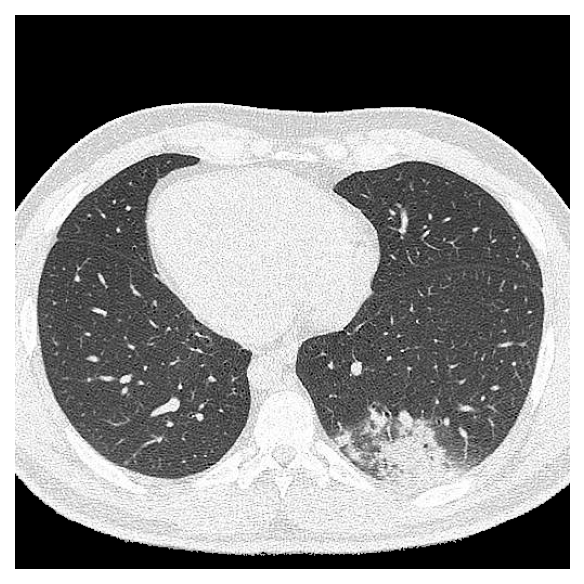

(1, 256, 256, 4)


In [74]:
idx = 340
mask_slice = test_mask[idx]
ct_slice = images[idx]
ct_slice = np.rot90(ct_slice, 3, (0, 1))

mask_slice = np.rot90(mask_slice, 3, (0, 1))

threshold = get_thresh(ct_slice)
ct_slice = seg_body(ct_slice[:, :, 0], threshold, img1=None, display=False)
show_img(ct_slice, is_gray=True)
ct_slice = np.expand_dims(ct_slice, axis=0).astype(np.float32)
mask_slice = np.expand_dims(mask_slice, axis=0)

seq2 = iaa.Sequential([iaa.Resize({"height": 256, "width": 256},  interpolation='area')])
ct_slice, mask_slice = seq2(images=ct_slice, segmentation_maps=mask_slice)
print(mask_slice.shape)
ct_slice = np.expand_dims(ct_slice, axis=0).astype(np.float32)
ct_slice = ct_slice / 255
ct_slice = ct_slice.astype(np.float32)
image_tensor = torch.from_numpy(ct_slice).to(device)

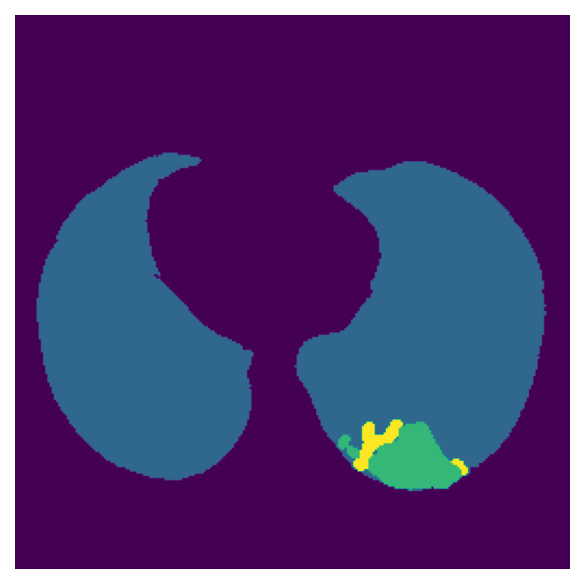

In [94]:
tmp_mask = onehot_to_mask(mask_slice, palette=[[3], [2], [1], [0]])
show_img(tmp_mask[0, :, :, 0])
# print(tmp_mask[0,0,0, 0])

In [75]:
T = 9
model.eval()
preds = torch.zeros([T, 4, image_tensor.shape[2], image_tensor.shape[3]]).cuda()
for i in range(T):
    tmp_input = image_tensor + torch.clamp(torch.randn_like(image_tensor) * 0.1, -0.2, 0.2)
    with torch.no_grad():
        preds[i] = model(tmp_input)[0]
        # preds[i] = model(image_tensor)[0]
# print(preds.size())
preds = F.softmax(preds, dim=1)
# print(preds.size())
preds = torch.mean(preds, dim=0)  #(batch, 2, 112,112,80)
uncertainty = -1.0*torch.sum(preds*torch.log(preds + 1e-6), dim=0, keepdim=True) #(batch, 1, 112,112,80)

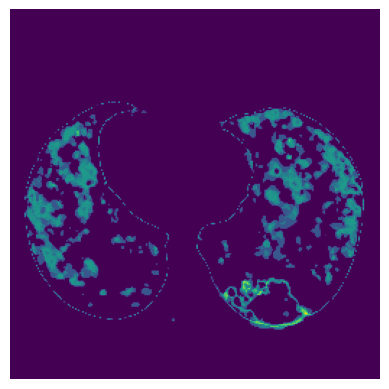

In [78]:
uncer = uncertainty[0].cpu().numpy()
# print(np.min(uncer*255))
# uncer = cv2.applyColorMap(np.uint8(255 * uncer), cv2.COLORMAP_JET)
# uncer = cv2.cvtColor(uncer, cv2.COLOR_BGR2RGB)
# uncer = np.float32(uncer) / 255

plt.imshow(uncer)
# plt.colorbar()
plt.axis("off")
plt.show()